# An Investigation of Crowd-Funding for Sacked Met Officers

In July 2020, the Metropoliton Police stopped, searched, and restrained athletes Bianca Williams and Ricardo dos Santos, on supposed suspicion of possesion of drugs and weapons, despite their child being present in their car. A [misconduct hearing](https://www.policeconduct.gov.uk/news/statement-following-misconduct-hearing-over-stop-and-search-bianca-williams-and-ricardo-dos) found that this was wholly unjustified, and two officers were dismissed for gross misconduct.

Bianca Williams was [reportedly shocked](https://www.bbc.co.uk/news/uk-england-london-67261517) at the amount of money raised by a
[crowd-funder](https://web.archive.org/web/20231031124058/https://www.justgiving.com/crowdfunding/Clapham-Franks) for the two officers.
The page states that comments have been taken down to "respect the impending Appeal". In fact, enabling developer tools and observing the network tab shows that that comments are still transmitted by API calls, and just not displayed. Some donations have a "userId" associated with them, and it is a simple matter to gather data for the crowd-funding campaign.

* Not all donations for a campaign are returned, but about 90% of funds are recorded.
* The Met Police campaign differs significantly from others.
* Over half of donations recorded by the API are attributable to a single user-ID. 

In [1]:
from functools import partial
from multiprocessing import Process
import os
import subprocess

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

The [Scrapy](https://scrapy.org/) [spider](https://docs.scrapy.org/en/latest/topics/spiders.html) crawls a specific type of [JustGiving crowd-funder page](https://www.justgiving.com/crowdfunding).

In [2]:
# In which we tell Scrapy to STFU.
quiet_run = partial(subprocess.run, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Run Scrapy spiders in another process, as but one Twisted Reactor is granted.
def get_campaign(campaign, fname):
    args = [
        'scrapy', 'crawl', 'crowdfunding', '-a', 'campaign={}'.format(campaign), '-o', fname
    ]
    if not os.path.isfile(fname):
        proc = Process(target=quiet_run, args=[args])
        proc.start()
        proc.join()
    df = pd.read_csv(fname)
    df.timestamp = pd.to_datetime(df.timestamp)
    return df

In [3]:
# Plot aggregated donation counts and amounts, ordered by rank.

def show_skew(df, ranks=20):
    donation_df = df[['user', 'amount']]
    sum_df = donation_df.groupby('user').agg('sum').reset_index().rename(
        columns={'amount': 'total'}).sort_values('total', ascending=False)
    count_df = donation_df.groupby('user').agg('count').reset_index().rename(
        columns={'amount': 'donations'}).sort_values('donations', ascending=False)
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    axs[0].bar(range(ranks), sum_df.head(ranks).total)
    axs[0].set_xlabel('rank')
    axs[0].set_ylabel('total donated')
    top_donation, = sum_df.head(1)['total']
    top_pc = round(100 * top_donation / df.amount.sum())
    axs[0].set_title("top donor donated {}% of total".format(top_pc))
    axs[1].bar(range(ranks), count_df.head(ranks).donations)
    axs[1].set_xlabel('rank')
    axs[1].set_ylabel('number of donations')
    top_count, = count_df.head(1)['donations']
    count_pc = round(100 * top_count / count_df.donations.sum())
    axs[1].set_title("top donor made {}% of named donations".format(count_pc))
    plt.show()

In [4]:
# Crawl the Met Police crowd-funder, and some others for comparsion:
random_df1 = get_campaign('inferior', 'random1.csv')
random_df2 = get_campaign('martingoodestandup', 'random2.csv')
random_df3 = get_campaign('skydiving-for-mind', 'random3.csv')

met_df = get_campaign('Clapham-Franks', 'met.csv')

## Other Crowd-Funding Campaigns

It is normal for some user-IDs to have multiple donations associated with them. For the 3 other campaigns investigated, between 15-25% of total donations come from a single user...

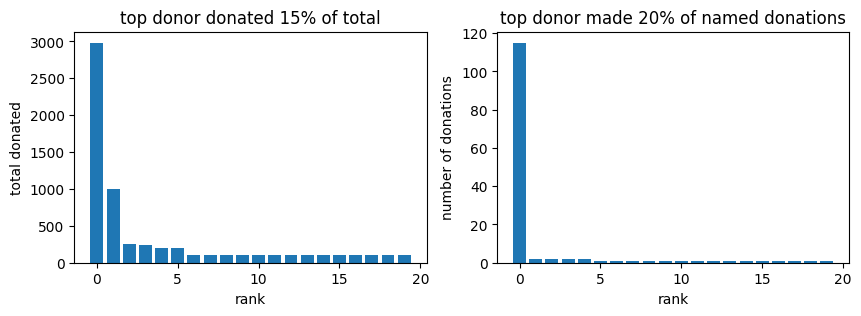

In [5]:
show_skew(random_df1)

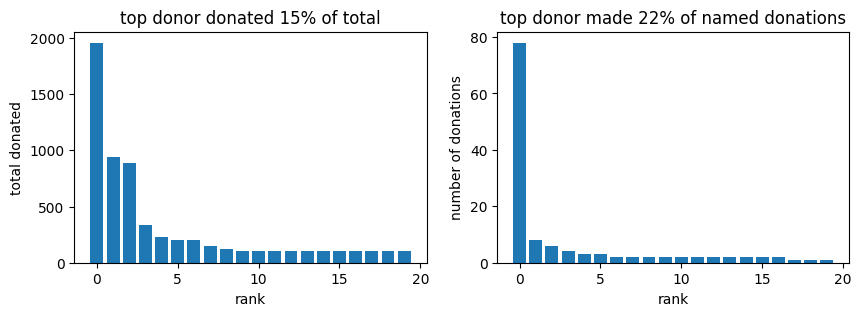

In [6]:
show_skew(random_df2)

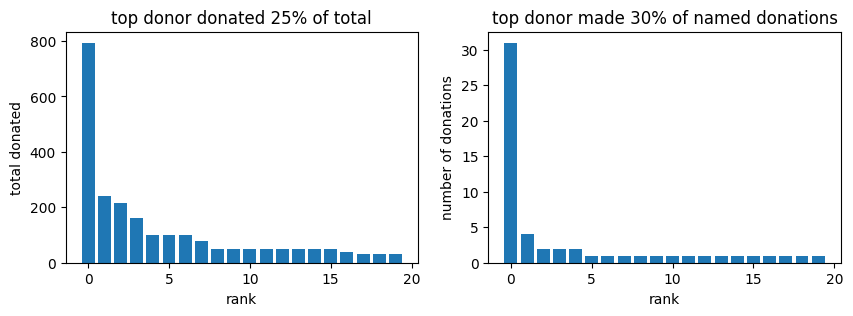

In [7]:
show_skew(random_df3)

...however, the Met Police campaign is utterly different. Over half of the donations for which the API returned an ammount come from a single user-ID. This user accounts for 99% of donations where a non-null ID was returned.

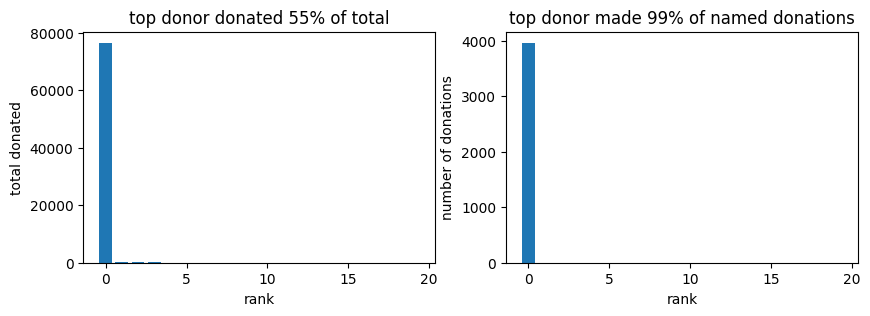

In [8]:
show_skew(met_df)

For the other campaigns, the highest donating user-ID appears only once, or a few times with consistent names:

In [9]:
top_user1, = random_df1.dropna().sort_values('amount', ascending = False).head(1)['user']
random_df1[random_df1.user == top_user1][['name', 'message']]

,name,message
308,Mark Crowther,Thank you. Needs doing.


In [10]:
top_user2, = random_df2.dropna().sort_values('amount', ascending = False).head(1)['user']
random_df2[random_df2.user == top_user2][['name', 'message']]

,name,message
45,Maria Madureira,Prize Draw Julie Simmons 44
51,Fatima Madureira,PRIZE DRAW 63❤ CHLOE
61,Fatima Madureira,PRIZE DRAW 14
101,Fatima Madureira,FAMILY FUN DAY 1 SEPTEMBER It was a pleasure t...
108,Fatima Madureira,LET'S END THIS TONIGHT IF YOU KNOW THE GOODE'S...
489,Fatima Madureira,Hi Natalie & Martin sorry is not much. Hope Ma...


In [11]:
top_user3, = random_df3.dropna().sort_values('amount', ascending = False).head(1)['user']
random_df3[random_df3.user == top_user3][['name', 'message']]

,name,message
12,Eve Pike,"""Good luck girls.Lots of love The Alexander fa..."


We shall tag the most prolific user-ID in the Met Police campaign "`mr_busy`":

In [12]:
mr_busy, = met_df.sort_values('amount', ascending = False).head(1)['user']

In [13]:
busy_df = met_df[met_df.user == mr_busy]
everyone_else_df = met_df[met_df.user != mr_busy]

In contrast, the top-donating user in the Met Police campaign is associated with many different names:

In [14]:
busy_df.sort_values('amount', ascending=False)[['name', 'timestamp', 'message', 'amount']].head(30)

,name,timestamp,message,amount
3942,A former Labour supporter,2023-10-28 00:23:55+00:00,The silent majority can see that these two off...,5000.0
7713,A Queen’s Peace Officer,2023-10-26 19:36:18+00:00,"Good luck, keep strong!",1000.0
6683,ANONYMOUS,2023-10-27 08:51:13+00:00,"Having read the report about the hearing, it’s...",500.0
246,U54,2023-10-31 19:53:24+00:00,Hopefully faith will be restored.,300.0
8237,U4:3,2023-10-26 15:07:33+00:00,NaN,280.0
8713,Dick Hart,2023-10-26 08:33:21+00:00,NaN,250.0
9137,SS,2023-10-25 20:36:00+00:00,Two of the best I have worked with. Your frien...,250.0
2023,Mike SHAW,2023-10-29 09:33:28+00:00,No doubt the Commissioner is over the Moon Ms ...,250.0
8200,Nigel Skinner,2023-10-26 15:35:05+00:00,Not the way you should be treated for trying t...,250.0
3797,Politically Motivated,2023-10-28 06:54:54+00:00,NaN,200.0


In [15]:
cum_busy_df = busy_df[['timestamp', 'amount']].dropna().sort_values('timestamp')
cum_busy_df['total'] = cum_busy_df.amount.cumsum()

cum_not_busy_df = everyone_else_df[['timestamp', 'amount']].dropna().sort_values('timestamp')
cum_not_busy_df['total'] = cum_not_busy_df.amount.cumsum()

The campaign was most active from 26/10/2023 to 01/11/2023, but the top donating user-ID dominated throughout:

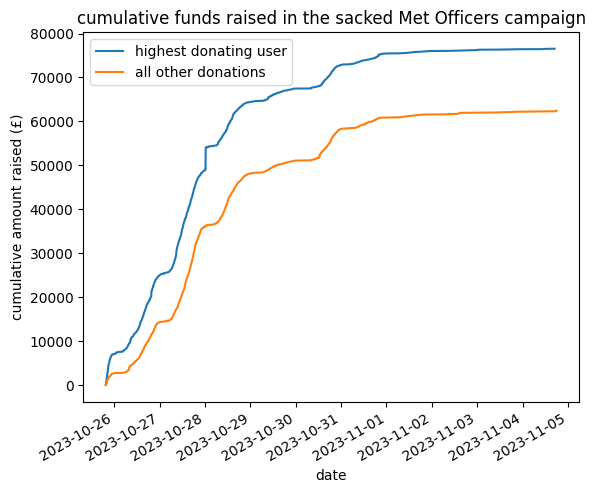

In [16]:
plt.plot(cum_busy_df.timestamp, cum_busy_df.total, label='highest donating user')
plt.plot(cum_not_busy_df.timestamp, cum_not_busy_df.total, label='all other donations')
plt.xlabel('date')
plt.ylabel('cumulative amount raised (£)')
plt.xticks(rotation=30, ha='right')
plt.title('cumulative funds raised in the sacked Met Officers campaign')
plt.legend()
plt.show()

The distribution of donation amounts is also rather different for the single highest donating user:

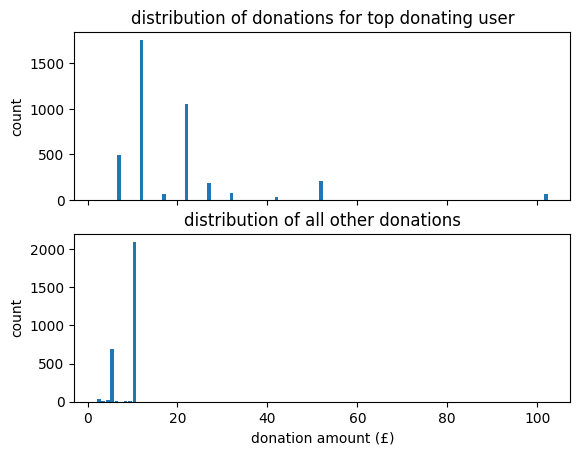

In [17]:
n_bins = 1000
busy_hist, busy_bins = np.histogram(busy_df.amount.dropna(), bins=n_bins)
hist, bins = np.histogram(everyone_else_df.amount.dropna(), bins=n_bins)

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].bar(busy_bins[1: 21], busy_hist[0:20])
axs[0].set_ylabel('count')
axs[0].set_title('distribution of donations for top donating user')
axs[1].bar(bins[1:21], hist[0:20])
axs[1].set_xlabel('donation amount (£)')
axs[1].set_ylabel('count')
axs[1].set_title('distribution of all other donations')

plt.show()

~70% of donations from the most prolific user-ID include a message, compared to ~20% for all other donations:

In [18]:
round(100 * busy_df.message.notna().sum() / len(busy_df))

73

In [19]:
round(100 * everyone_else_df.message.notna().sum() / len(everyone_else_df))

21

130 messages accuse the hearing of being "woke":

In [20]:
messages = met_df[met_df.message.notna()].message
woke_msg = [msg for msg in messages if 'woke' in msg.lower()]

In [21]:
len(woke_msg)

130

In [22]:
for msg in woke_msg:
    print(msg)

Disgusting what happened to these two police officers... Wokeness and Madness
Woke, racist action by the Met
Sorry to read Tribunals decision. Appears that support for people in the public sector is sadly missing in the woke society that we live in today. 
You are scapegoats for a woke biased British court system
Victims of race-baiters and unfairly dismissed by woke system.  I've seen several videos of this incident, and you both acted fairly and professionally.  Good luck for your futures.
good officers persecuted for doing their job. has the world gone mad, woke?
Woke, weak, gesture politics inspired bullshit decision, not proportionate, way over the top, milked by the 2 in the car after a compensation payout
Disgraceful decision, woke Wankers are ruining this country and its institutions. 
You may have been thrown under the bus to please the woke mob but the rest of us know this wasn’t deserved
sorry for what happened to you guys, victims of the woke mob
Support the police and end 